In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.animation as animation
from IPython.display import HTML, Image
import glob


In [4]:
img = plt.imread('./seaturtle.png')
test = plt.imread('./cat.png')
x = np.array([[300, 100, 1],
     [400, 550, 1],
     [700, 300, 1]])

xprime = np.array([[400, 200, 1],
     [600, 550, 1],
     [800, 300, 1]])


tri_src = np.array([[ 82, 220, 350],
                    [158, 338, 158],
                    [1, 1, 1]]).T

tri_dst = np.array([[ 248, 498, 452],
                    [316, 246, 96],
                    [1, 1, 1]]).T

# Size of destination image:
height = 406
width = 766


(730, 1048, 4)


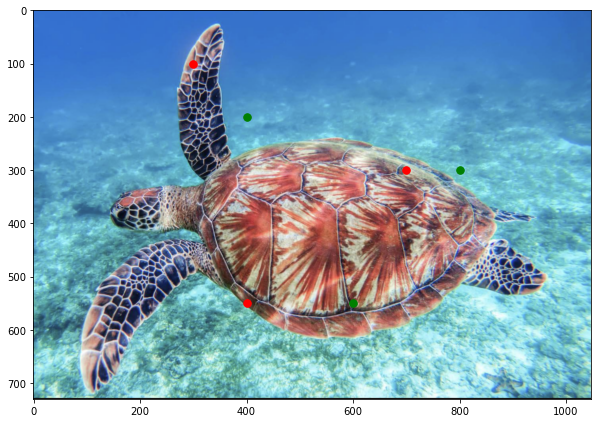

In [5]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
ax1.imshow(img)
ax1.plot(x[:,0], x[:,1], '.',c = 'r', markersize = 15)
ax1.plot(xprime[:,0], xprime[:,1], '.',c = 'g', markersize = 15)
# ax1.imshow(test)
# ax1.plot(tri_src[:,0], tri_src[:,1], '.',c = 'r', markersize = 15)
# ax1.plot(tri_dst[:,0], tri_dst[:,1], '.',c = 'g', markersize = 15)
print(img.shape)
plt.show()

In [11]:
def boundaries(x, y, nrows, ncols):
    return (x >= 0 and x < nrows and y >= 0 and y < ncols)

def getsize(A, image):
    
    maxX,maxY = image.shape[:2]
    
    corners = np.array([[0, maxX, 0, maxX],
                        [0,0,maxY, maxY],
                        [1, 1, 1, 1]])
    
    
    warpedcorners = A @ corners
    # print(warpedcorners)
    xmin, ymin = np.ceil(np.min(warpedcorners[:2, :], axis = 1)).astype(int)
    xmax, ymax = np.ceil(np.max(warpedcorners[:2, :], axis = 1)).astype(int)
    
    nrows = xmax-abs(xmin)
    
    ncols = ymax-abs(ymin)
    
    # print(xmin, ymin, nrows, ncols)
    
    # print((np.linalg.inv(A) @ warpedcorners).astype(np.uint32))
    
    return maxX, maxY ,abs(xmin), abs(ymin), nrows, ncols

def EstimateAffine(x, xprime):
    M = np.block([[x, np.zeros((3,3))], [np.zeros((3,3)), x]])
    # print(M)
    b = xprime[:,:2].T.reshape(6,1)
    # print(b)
    
    zeros = np.zeros((1,3))
    zeros[0][-1] = 1
    # print(zeros)
    a = np.linalg.inv(M) @ b
    # print(a)
    A = np.vstack([a.reshape(2,3), zeros])
    # print(A)
    return A


def InverseMapping(x, xprime, src):
    # nrows, ncols = getsize(coord)
    
    print(src.shape)

    A = EstimateAffine(x, xprime)
    
    xbound, ybound, xmin, ymin, nrows, ncols = getsize(A, src)
    
    I = np.zeros((nrows+xmin, ncols+ymin, 3))
        
    A_inv = np.linalg.inv(A)
    
    # xbound, ybound, xmin, ymin, nrows, ncols = getsize(A, src)

    
    # nrows, ncols = getimagesize(xprime)
    # print(xmin, ymin)
    # print(nrows, ncols)
    # print(I.shape)
    
    #(2, 730, 1048) -> reshape to (2, 765040) -> transpose to (765040, 2) 
    coordbase = np.mgrid[0:nrows+xmin:1, 0:ncols+ymin:1].reshape(2,-1).T
    # print(coordbase[:5].T)
    # print(coordbase.shape)
    
    #Make homogenous because I'm lazy for loops
    coord = np.hstack([coordbase, np.ones((coordbase.shape[0],1))]).astype(np.uint32)
    # print(coord[:5].T)
    # print(coord.shape)
    
        #being lazy with loops 
    colormapping = (A_inv @ coord.T).T.astype(np.uint32)

    for d, i in zip(coordbase, colormapping):
        # print(d)
        # print(i)
        # break
        
        if boundaries(i[0],i[1], xbound, ybound): 
            # print(d)
            # if (count%100000 == 0):
            I[d[0],d[1]] = src[i[0], i[1], :3]
    
#     print(np.amax(coordbase[:,0]), np.amax(coordbase[:,1]))
#     print(np.amax(colormapping[:,0]), np.amax(colormapping[:,1]))

    return I


def RegularMapping(x, xprime, src):
    # nrows, ncols = getsize(coord)
    
    print(src.shape)

    A = EstimateAffine(x, xprime)
    
    xbound, ybound, xmin, ymin, nrows, ncols = getsize(A, src)
    
    I = np.zeros((nrows, ncols, 3))
        
    A_inv = np.linalg.inv(A)
    
    print(xmin, ymin)
    print(nrows, ncols)
    
    #(2, 730, 1048) -> reshape to (2, 765040) -> transpose to (765040, 2) 
    coordbase = np.mgrid[0:nrows:1, 0:ncols:1].reshape(2,-1).T
    # print(coordbase[:5].T)
    # print(coordbase.shape)
    
    #Make homogenous because I'm lazy for loops
    coord = np.hstack([coordbase, np.ones((coordbase.shape[0],1))]).astype(np.uint32)
    
    #being lazy with loops 
    colormapping = (A @ coord.T).T.astype(np.uint32)
    
    for d, i in zip(coordbase, colormapping):
        
        if boundaries(d[0],d[1], xbound, ybound): 
            I[i[0],i[1]] = src[d[0], d[1], :3]
            
    return I

(400, 458, 4)
(3, 3)


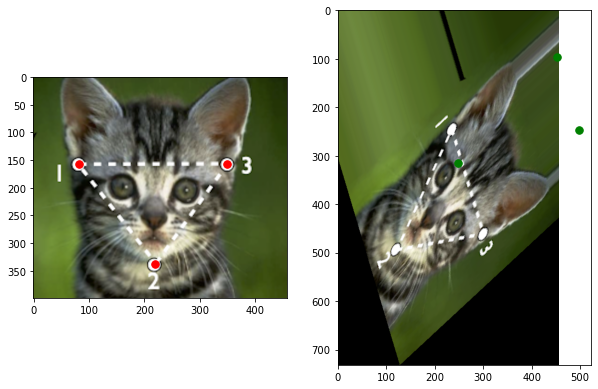

In [19]:
fig2 = plt.figure(figsize = (10,10))
ax2 = fig2.add_subplot(121)
ax2.imshow(test)
ax2.plot(tri_src[:,0], tri_src[:,1], '.',c = 'r', markersize = 15)
# ax1.plot(xprime[:,0], xprime[:,1], '.',c = 'g', markersize = 15)
ax3 = fig2.add_subplot(122)
I = InverseMapping(tri_src,tri_dst,test)
ax3.imshow(I)

point_test = tri_dst.copy() 

print(point_test.shape)

# ax3.invert_xaxis()
ax3.plot(tri_dst[:,0], tri_dst[:,1], '.',c = 'g', markersize = 15)
plt.show()

(730, 1048, 4)
(1014, 1018, 3)


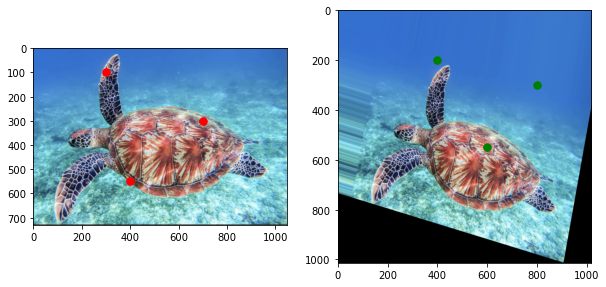

In [25]:
fig2 = plt.figure(figsize = (10,10))
ax2 = fig2.add_subplot(121)
ax2.imshow(img)
ax2.plot(x[:,0], x[:,1], '.',c = 'r', markersize = 15)
# ax1.plot(xprime[:,0], xprime[:,1], '.',c = 'g', markersize = 15)
ax3 = fig2.add_subplot(122)


I = InverseMapping(x,xprime,img)


print(I.shape)
ax3.imshow(I)
ax3.plot(xprime[:,0], xprime[:,1], '.',c = 'g', markersize = 15)
plt.show()